In [1]:
"""
This cell creates waveforms with just a simple afterpulsing+crosstalk model -- only one cross talk event
can be created with uniform probability. Same with afterpulsing. 

Cells below implement a model where the number of cross talk events depends on a borel distribution
"""

position = 0

t0s = [] # an array of all of the positions of the t0s 
dts = [] # an array of all of the delay times between dark count events
xt_t0s = [] # an array of all of the positions of cross talk events
xt_dts = []
ap_t0s = [] # an array of all positions of afterpulsing events 
ap_dts = [] # an array of all of the afterpulse delay times, can check against it later

# Keep sampling until we are outside the waveform 
while position < wf_len: 
    dt0 = expon.rvs(0, DCR, size=1)[0] # the exponential distribution is defined by loc, scale like anything in scipy.stats
    
    # Advance the position by this dt
    position += dt0
    
    # If we're still inside the wf_len, then save it and the delay time 
    # Save the dark counts
    dts.append(dt0)
    t0s.append(position)
    
    # Now see if we get any XTs or APs
    if P_xt >= uniform.rvs(size=1)[0]:
        # The number of XT events is determined by a Borel distribution 
        xt_t0s.append(position)
        xt_dts.append(dt0)
        
    if P_ap >= uniform.rvs(size=1)[0]:
        # The number of AP events from the k-number of XT events above is determined by a Binomial distribution
        dt_ap = expon.rvs(0, AP_rate, size=1)[0] 
        if position + dt_ap <= wf_len:
            ap_t0s.append(position+dt_ap)
            ap_dts.append(dt_ap)
    
    
    
    

NameError: name 'wf_len' is not defined

In [ ]:
"""
this function works, but the afterpulsing probability suffers slightly due to the fact that more than 1 afterpulses might be created
"""


position = 0
mu = 1-(1/avg_xt_num) # shape parameter of the Borel distribution for XT

t0s = [] # an array of all of the positions of the t0s 
dts = [] # an array of all of the delay times between dark count events

xt_t0s = [] # an array of all of the positions of cross talk events
xt_dts = [] 
num_xts = [] # an array containing the number of cross talk discharges 

ap_t0s = [] # an array of all positions of afterpulsing events 
ap_dts = [] # an array of all of the afterpulse delay times, can check against it later
num_aps = [] # an array containing the number of afterpulses from k-number of XT events, based on a binomial
num_xts_per_ap = []

# Keep sampling until we are outside the waveform 
while position < wf_len: 
    dt0 = expon.rvs(0, DCR, size=1)[0] # the exponential distribution is defined by loc, scale like anything in scipy.stats
    
    # Advance the position by this dt
    position += dt0
    
    # If we're still inside the wf_len, then save it and the delay time 
    # Save the dark counts
    dts.append(dt0)
    t0s.append(position)
    
    # Now see if we get any XTs or APs
    num = 1 # set default to the 1 DC already created
    if P_xt >= uniform.rvs(size=1)[0]:
        # The number of XT events is determined by a Borel distribution 
        num += borel.rvs(mu, size=1)[0]
        num_xts.append(num)
        xt_t0s.append(position)
        xt_dts.append(dt0)
        
    num_ap = 0
    if P_ap >= uniform.rvs(size=1)[0]:
        # The number of AP events from the k-number of XT events above is determined by a Binomial distribution
        while num_ap == 0: # make sure we don't get 0 afterpulses 
            num_ap = binom.rvs(num, alpha, size=1)[0]
        num_aps.append(num_ap)
        for i in range(num_ap):
            num_xts_per_ap.append(num)
            dt_ap = expon.rvs(0, AP_rate, size=1)[0] 
            if position + dt_ap <= wf_len:
                ap_t0s.append(position+dt_ap)
                ap_dts.append(dt_ap)

    
    
    

# Goal: Create a series of syntehtic waveforms with SiPM characteristics exactly known so that we can test how well sipm_studio recovers the parameters 

The user can set the gain, DCR, AP and XT probabilities and this code should simulate a series of waveforms with those parameters. The individual pulses can be created using the Duara model for the SiPM electronics response. The timing and character of the pulses can be set by sampling a Poisson distribution. Here's an outline of how the code should work 

1. The user specifies the gain, DCR, AP and XT probabilities, as well as the number of waveforms and length of each waveform 
2. We start the waveform with a pulse, and then sample an Exponential distribution for the inter-event time from that pulse to the next one. Recall that for poisson processes, the interevent times are exponentially distributed
3. Each time a pulse is registered, another distribution (uniform) is sampled to see if this event creates a direct cross talk event, and/or if there is an afterpulsing event. Maybe take a Borel distribution to find out how many DiCT events there are. The number of afterpulses is determined by a binomial distribution from number of direct cross talk events. The afterpulsing events are then distributed among the recovery time of the cell with a Poisson distribution, and a random Gaussian distribution around 0.5 p.e. draws their amplitude. 
4. Each pulse's amplitude is multiplied by a scaling drawn from a Gaussian with some sigma, distributed around unity 
5. All of the pulses are then added together. (I guess that means each pulse has the same waveform length, we just roll where the pulse starts and stops in the range)

We first go through a waveform and find all of the t0s for each of these three types of pulses, and then in a later step, we modify the amplitude of these pulses by drawing them from either a Gaussian (DCR + AP) or Borel (DiCT) distribution. 

If this simulation works well enough, we could use Iminuit to create a function that will just run this simulation with a variety of parameters until we reproduce a measured dt/QPE spectrum....


In [2]:
gain = 1.7e6 # typical gain from a SiPM 
DCR = 300 # this is in counts per second, let's convert to samples using the sampling rate of the digitizer

P_xt = 0.1 # these are made up, but probability that a DC creates direct cross talk
avg_xt_num = 5 # average number of direct cross talk discharges per DC


P_ap = 0.05 # also made up, probability for afterpulsing 
AP_rate = 30 # no idea, just again assume exponential inter-time from the main DC, this is also the cell recovery time!
alpha = 0.001 # probability that Geiger discharge (from DC + XT events) causes an AP, keep this extremely small

sampling_rate = 1 # 2ns per sample 
DCR /= sampling_rate # DCR in counts/sample


In [3]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import poisson, norm, binom, uniform, expon
from scipy.stats import linregress

In [4]:
from scipy.stats import rv_continuous
from scipy.special import gamma 

from scipy.stats import rv_continuous, rv_discrete
from scipy.special import gamma, gammaln

class borel_gen(rv_discrete): 
    """
    Create a class with methods that compute a Borel distribution 
    """
    
    def _pmf(self, n, mu):
        r"""
        Computes the pmf for a Borel distribution $P(n, \mu) = \frac{e^{-\mu n}(\mu n)^{n-1}}{n!}$
        """
        
        return  ((mu*n)**(n-1))/(gamma(n+1)*np.exp(mu * n))
    def _logpmf(self, n, mu):
        r"""
        Computes the log of pmf for a Borel distribution $P(n, \mu) = -\mu n + (n-1)\log(\mu n)-\log(n!)$
        """
        return -mu*n + (n-1)*np.log(mu*n) - gammaln(n+1)

    
borel = borel_gen(a=1, name='borel')

In [5]:
wf_len = 2e7

In [6]:
"""
TODO: we might not need to sample from the uniform distribution for AP, we might just straight up sample the binomial
as a 0 count from the binomial distribution is possible -- see if this way we can recover the afterpulsing probability
"""

position = 0
mu = 1-(1/avg_xt_num) # shape parameter of the Borel distribution for XT

t0s = [] # an array of all of the positions of the t0s 
dts = [] # an array of all of the delay times between dark count events

xt_t0s = [] # an array of all of the positions of cross talk events
xt_dts = [] 
num_xts = [] # an array containing the number of cross talk discharges 

ap_t0s = [] # an array of all positions of afterpulsing events 
ap_dts = [] # an array of all of the afterpulse delay times, can check against it later
num_aps = [] # an array containing the number of afterpulses from k-number of XT events, based on a binomial
num_xts_per_ap = []

# Keep sampling until we are outside the waveform 
while position < wf_len: 
    dt0 = expon.rvs(0, DCR, size=1)[0] # the exponential distribution is defined by loc, scale like anything in scipy.stats
    
    # Advance the position by this dt
    position += dt0
    
    if position in ap_t0s:
        pass
    
    
    # Now see if we get any XTs or APs
    num = 1 # set default to the 1 DC already created
    if P_xt >= uniform.rvs(size=1)[0]:
        # The number of XT events is determined by a Borel distribution 
        num += borel.rvs(mu, size=1)[0]
        num_xts.append(num)
        xt_t0s.append(position)
        xt_dts.append(dt0)
        
    else:
        # If we're still inside the wf_len, then save it and the delay time 
        # Save the dark counts
        dts.append(dt0)
        t0s.append(position)
        
    num_ap = 0
    if P_ap >= uniform.rvs(size=1)[0]:
        # The number of AP events from the k-number of XT events above is determined by a Binomial distribution
        while num_ap == 0: # make sure we don't get 0 afterpulses 
            num_ap = binom.rvs(num, alpha, size=1)[0] + 1
        num_aps.append(num_ap)
        for i in range(num_ap):
            dt_ap = expon.rvs(0, AP_rate, size=1)[0] 
            if position + dt_ap <= wf_len:
                num_xts_per_ap.append(num)
                ap_t0s.append(position+dt_ap)
                ap_dts.append(dt_ap)

    
    
    

/var/folders/n3/d9ywgw252xj7p9mh598g00nh0000gn/T/ipykernel_94500/3824198960.py:17: RuntimeWarning: overflow encountered in multiply
  return  ((mu*n)**(n-1))/(gamma(n+1)*np.exp(mu * n))
/var/folders/n3/d9ywgw252xj7p9mh598g00nh0000gn/T/ipykernel_94500/3824198960.py:17: RuntimeWarning: overflow encountered in power
  return  ((mu*n)**(n-1))/(gamma(n+1)*np.exp(mu * n))
/var/folders/n3/d9ywgw252xj7p9mh598g00nh0000gn/T/ipykernel_94500/3824198960.py:17: RuntimeWarning: invalid value encountered in true_divide
  return  ((mu*n)**(n-1))/(gamma(n+1)*np.exp(mu * n))


0.011801488095334494


<Figure size 640x480 with 0 Axes>

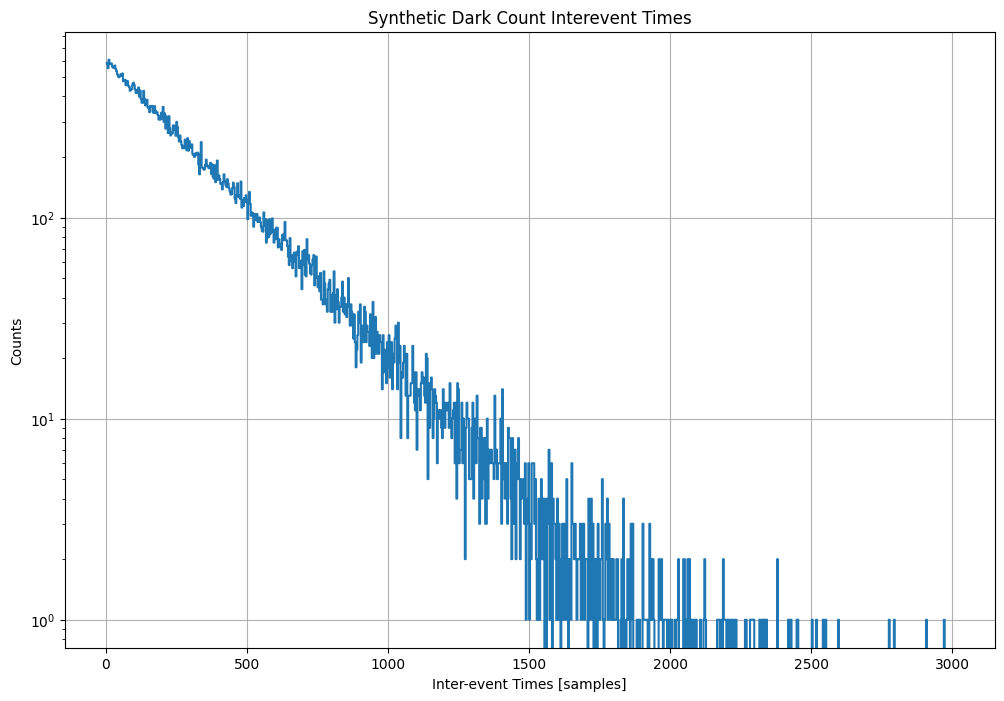

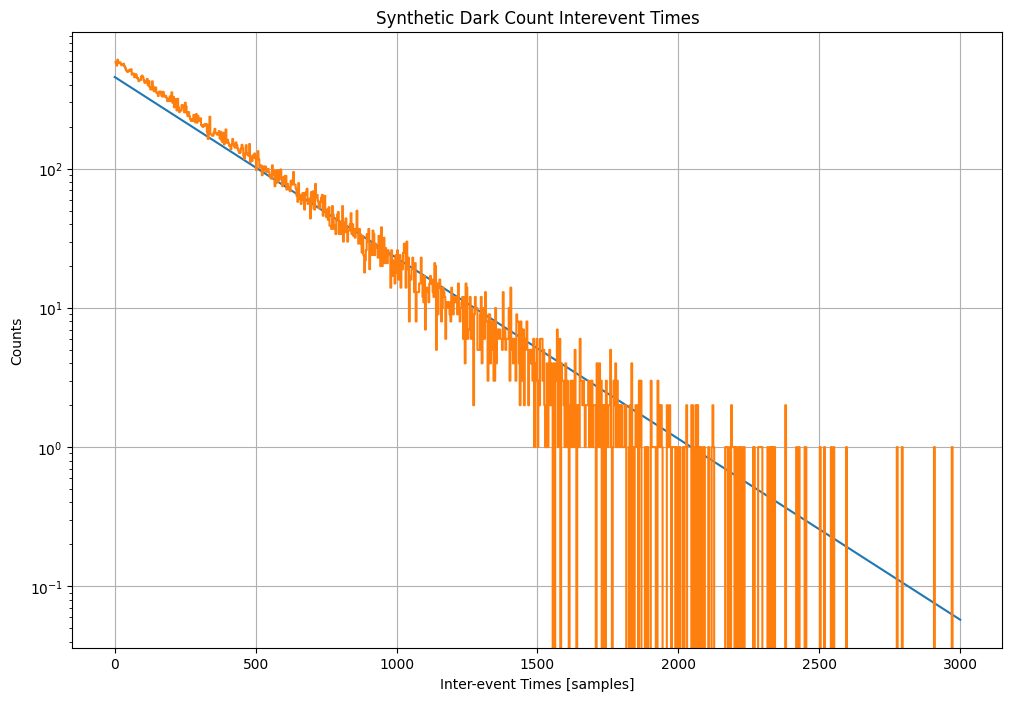

333.97265916153555
6.125409423572659


In [26]:
print(np.amin(dts))
n, bins, _ = plt.hist(dts, bins = 1000, range=[0, 3000])
plt.clf()

plt.figure(figsize=(12,8))
plt.step(bins[1:], n)
plt.title("Synthetic Dark Count Interevent Times")
plt.xlabel("Inter-event Times [samples]")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.show()

def fit_exp(x, y):
    x_new = x[y > 0]
    y_new = y[y > 0]
    ln_y = np.log(y_new)
    slope, intercept, r, p, stderr = linregress(x_new, ln_y)
    scale = (1)
    return abs(slope)*scale, stderr*scale, slope, intercept

bin_centers = (bins[1:] + bins[:-1]) / 2
rate, error, slope, intercept = fit_exp(bin_centers, n)

inter_times = np.linspace(0, 3000, 100)
exp_func = np.exp(intercept + slope*inter_times)
plt.figure(figsize=(12,8))
plt.plot(inter_times, exp_func)
plt.step(bins[1:], n)
plt.title("Synthetic Dark Count Interevent Times")
plt.xlabel("Inter-event Times [samples]")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.show()

print(1/rate)
print(intercept)


<Figure size 640x480 with 0 Axes>

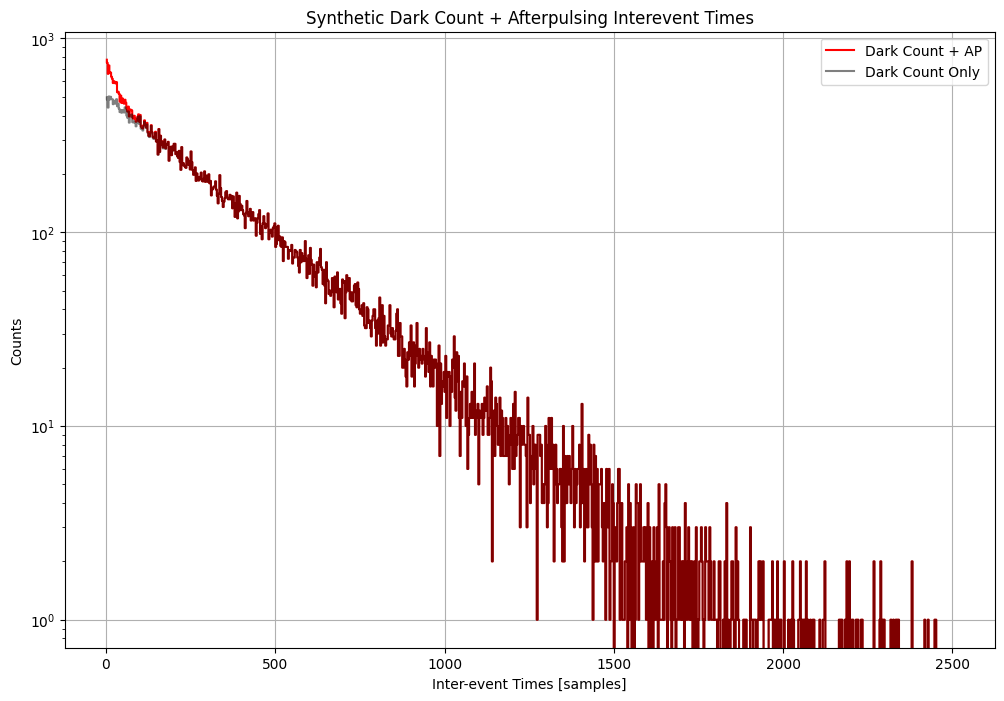

In [27]:
all_dts = np.append(dts, ap_dts)
n_ap, bins_ap, _ = plt.hist(all_dts, bins = 1000, range = [0,2500])
n, bins, _ = plt.hist(dts, bins = 1000, range = [0,2500])
plt.clf()

plt.figure(figsize=(12,8))
plt.step(bins_ap[1:], n_ap, label = 'Dark Count + AP', c='r')
plt.step(bins[1:], n, label = 'Dark Count Only', alpha= 0.5, c='k')
plt.title("Synthetic Dark Count + Afterpulsing Interevent Times")
plt.xlabel("Inter-event Times [samples]")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

## Now create the code that will modify the amplitudes
Eventually use these amplitudes to modify the actual modeled SiPM pulses put into the waveform 

In [28]:
mu_dcr = 1
# sigma_dcr = 0.1

sigma_detector = 0.12


amps = norm.rvs(mu_dcr, sigma_detector, size=len(t0s)) # dark counts have amps within 0.1 sigma of 1 

# Convolve the Borel XTs with a Gaussian detector response 
xt_amps = norm.rvs(1, sigma_detector, size=len(xt_t0s))
xt_amps = xt_amps*np.array(num_xts)

# Afterpulses have an amplitude that varies with ratio of the delay time from primary dcr and the recovery time 
def ap_recovery(dts, recovery_time):
    return 1-np.exp(-1*np.array(dts)/recovery_time)

ap_amps = ap_recovery(ap_dts, AP_rate)
ap_amps = np.array(num_xts_per_ap) * ap_amps
# maybe multiply them by the cross talk height?
# then convolve them with a Gaussian detector response 
ap_amps = ap_amps * norm.rvs(1, sigma_detector, size=len(ap_t0s)) 

In [29]:
all_amps = np.append(amps, xt_amps)
all_amps = np.append(all_amps, ap_amps )

<Figure size 640x480 with 0 Axes>

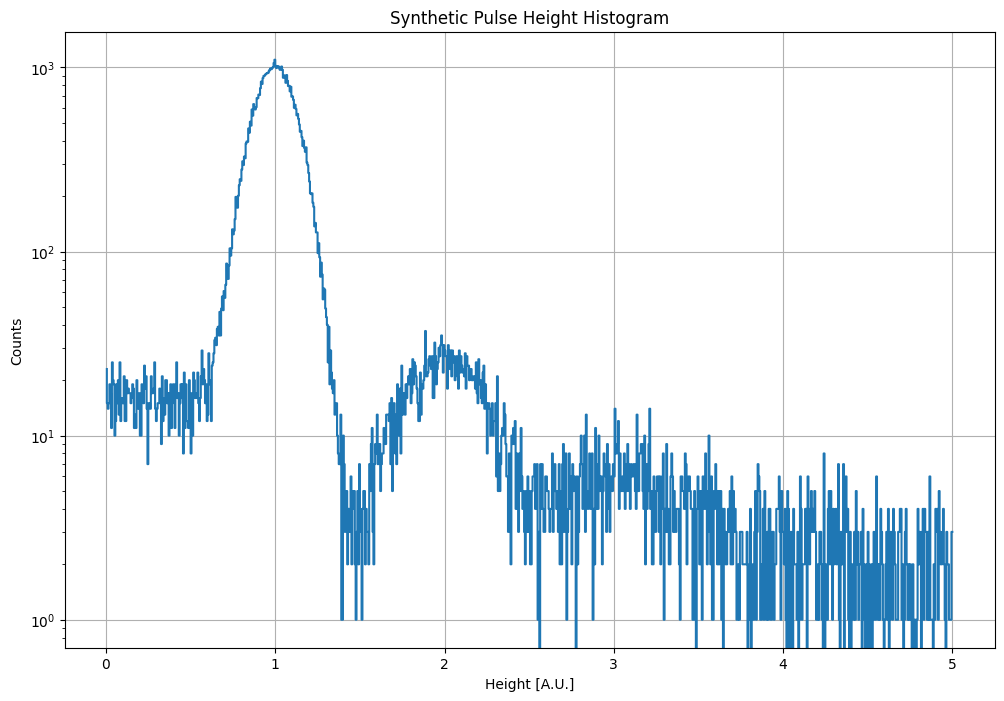

In [30]:
n, bins, _ = plt.hist(all_amps, bins = 1000, range = [0,5])
plt.clf()

plt.figure(figsize=(12,8))
plt.step(bins[1:], n)
plt.title("Synthetic Pulse Height Histogram")
plt.xlabel("Height [A.U.]")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.show()

In [31]:
calc_xt = len(xt_t0s)/(len(t0s)+len(xt_t0s))
calc_ap = len(ap_t0s)/(len(t0s)+len(xt_t0s))

print(calc_ap)
print(calc_xt)

0.04984079051619751
0.09873977845215494


In [12]:
print("percent error on afterpulse is", 100*(np.abs(calc_ap-P_ap)/P_ap))
print("percent error on cross talk is", 100*(np.abs(calc_xt - P_xt)/P_xt))

percent error on afterpulse is 1.6767834605445064
percent error on cross talk is 1.7789530620830467


## Make the 2d inter-event time plot 


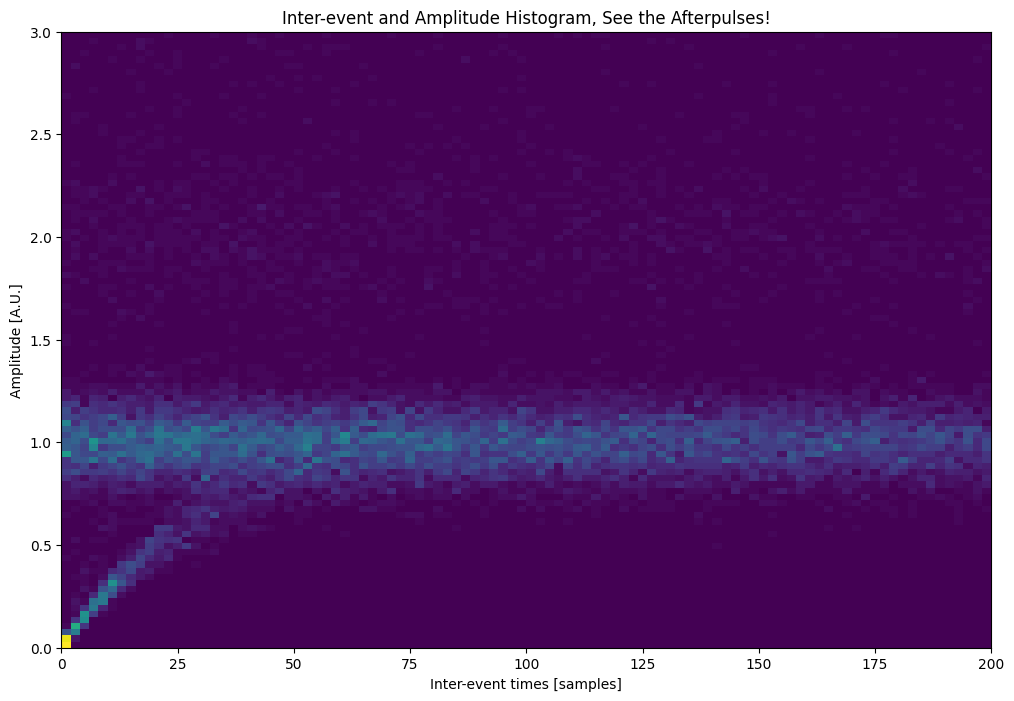

In [13]:
all_dts = np.append(dts, xt_dts)
all_dts = np.append(all_dts, ap_dts)

plt.figure(figsize=(12, 8))
plt.hist2d(all_dts, all_amps, range = [[0, 200], [0,3]], bins=100)
plt.title("Inter-event and Amplitude Histogram, See the Afterpulses!")
plt.xlabel("Inter-event times [samples]")
plt.ylabel("Amplitude [A.U.]")
plt.show()

## Now, get everything to run on smaller waveforms, but loop over a total number of waveforms 

In [32]:
num_wfs = 2000
wf_len = 6000

In [33]:
"""
TODO: we might not need to sample from the uniform distribution for AP, we might just straight up sample the binomial
as a 0 count from the binomial distribution is possible -- see if this way we can recover the afterpulsing probability
"""


mu = 1-(1/avg_xt_num) # shape parameter of the Borel distribution for XT



wf_t0s = [] # an array of all of the positions of the t0s 
wf_dts = [] # an array of all of the delay times between dark count events

wf_xt_t0s = [] # an array of all of the positions of cross talk events
wf_xt_dts = [] 
wf_num_xts = [] # an array containing the number of cross talk discharges 

wf_ap_t0s = [] # an array of all positions of afterpulsing events 
wf_ap_dts = [] # an array of all of the afterpulse delay times, can check against it later
wf_num_aps = [] # an array containing the number of afterpulses from k-number of XT events, based on a binomial
wf_num_xts_per_ap = []


for i in range(num_wfs):
    # Keep sampling until we are outside the waveform
    t0s = [] # an array of all of the positions of the t0s 
    dts = [] # an array of all of the delay times between dark count events

    xt_t0s = [] # an array of all of the positions of cross talk events
    xt_dts = [] 
    num_xts = [] # an array containing the number of cross talk discharges 

    ap_t0s = [] # an array of all positions of afterpulsing events 
    ap_dts = [] # an array of all of the afterpulse delay times, can check against it later
    num_aps = [] # an array containing the number of afterpulses from k-number of XT events, based on a binomial
    num_xts_per_ap = []

    position = 0
    while position < wf_len: 
        dt0 = expon.rvs(0, DCR, size=1)[0] # the exponential distribution is defined by loc, scale like anything in scipy.stats

        # Advance the position by this dt
        position += dt0
        
        if position in ap_dts:
            pass
        

        # Now see if we get any XTs or APs
        num = 1 # set default to the 1 DC already created
        if P_xt >= uniform.rvs(size=1)[0]:
            # The number of XT events is determined by a Borel distribution 
            num += borel.rvs(mu, size=1)[0]
            num_xts.append(num)
            xt_t0s.append(position)
            xt_dts.append(dt0)
            
        else:
            # If we're still inside the wf_len, then save it and the delay time 
            # Save the dark counts
            dts.append(dt0)
            t0s.append(position)

        num_ap = 0
        if P_ap >= uniform.rvs(size=1)[0]:
            # The number of AP events from the k-number of XT events above is determined by a Binomial distribution
            while num_ap == 0: # make sure we don't get 0 afterpulses 
                num_ap = binom.rvs(num, alpha, size=1)[0] + 1
            num_aps.append(num_ap)
            for i in range(num_ap):
                dt_ap = expon.rvs(0, AP_rate, size=1)[0] 
                if position + dt_ap <= wf_len:
                    num_xts_per_ap.append(num)
                    ap_t0s.append(position+dt_ap)
                    ap_dts.append(dt_ap)


    wf_dts.extend(dts)
    wf_t0s.extend(t0s) # append
    wf_num_xts.extend(num_xts) # append
    wf_xt_t0s.extend(xt_t0s) # append
    wf_xt_dts.extend(xt_dts)
    wf_num_aps.extend(num_aps)  # append
    wf_num_xts_per_ap.extend(num_xts_per_ap)  # append
    wf_ap_t0s.extend(ap_t0s)  # append
    wf_ap_dts.extend(ap_dts)
    
    


/var/folders/n3/d9ywgw252xj7p9mh598g00nh0000gn/T/ipykernel_70665/3824198960.py:17: RuntimeWarning: overflow encountered in multiply
  return  ((mu*n)**(n-1))/(gamma(n+1)*np.exp(mu * n))
/var/folders/n3/d9ywgw252xj7p9mh598g00nh0000gn/T/ipykernel_70665/3824198960.py:17: RuntimeWarning: overflow encountered in power
  return  ((mu*n)**(n-1))/(gamma(n+1)*np.exp(mu * n))
/var/folders/n3/d9ywgw252xj7p9mh598g00nh0000gn/T/ipykernel_70665/3824198960.py:17: RuntimeWarning: invalid value encountered in true_divide
  return  ((mu*n)**(n-1))/(gamma(n+1)*np.exp(mu * n))


37645


<Figure size 640x480 with 0 Axes>

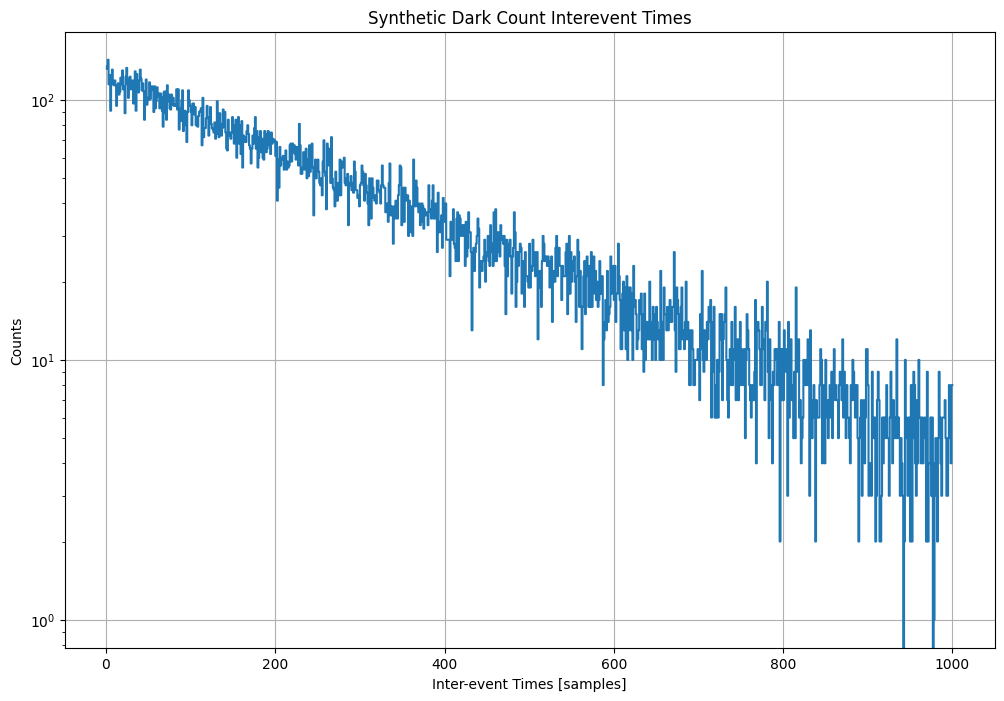

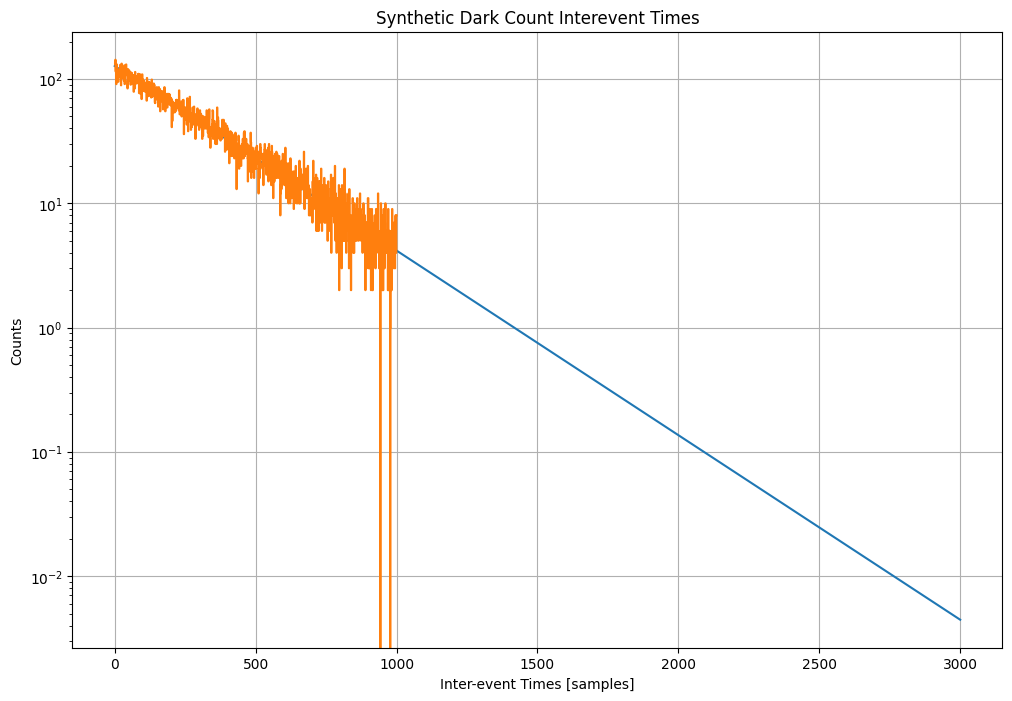

292.41350573512716


In [34]:
print(len(wf_dts))
n, bins, _ = plt.hist(wf_dts, bins = 1000, range=[0,1000])
plt.clf()

plt.figure(figsize=(12,8))
plt.step(bins[1:], n)
plt.title("Synthetic Dark Count Interevent Times")
plt.xlabel("Inter-event Times [samples]")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.show()

def fit_exp(x, y):
    x_new = x[y > 0]
    y_new = y[y > 0]
    ln_y = np.log(y_new)
    slope, intercept, r, p, stderr = linregress(x_new, ln_y)
    scale = (1)
    return abs(slope)*scale, stderr*scale, slope, intercept

bin_centers = (bins[1:] + bins[:-1]) / 2
rate, error, slope, intercept = fit_exp(bin_centers, n)

inter_times = np.linspace(0, 3000, 100)
exp_func = np.exp(intercept + slope*inter_times)
plt.figure(figsize=(12,8))
plt.plot(inter_times, exp_func)
plt.step(bins[1:], n)
plt.title("Synthetic Dark Count Interevent Times")
plt.xlabel("Inter-event Times [samples]")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.show()

print(1/rate)

<Figure size 640x480 with 0 Axes>

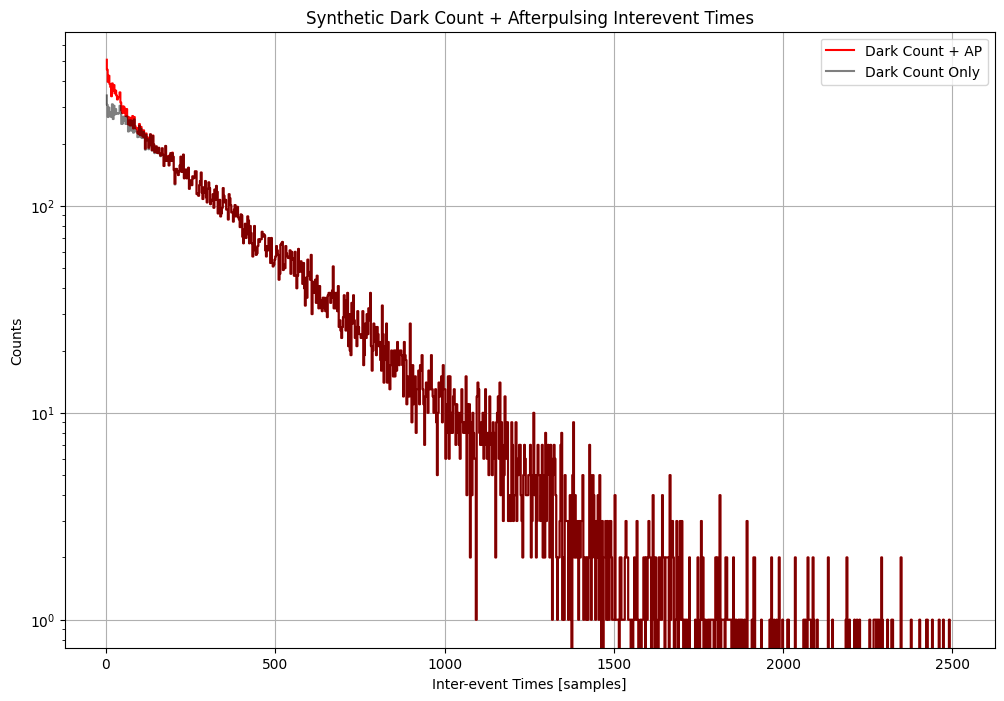

In [35]:
all_dts = np.append(wf_dts, wf_ap_dts)
n_ap, bins_ap, _ = plt.hist(all_dts, bins = 1000, range = [0,2500])
n, bins, _ = plt.hist(wf_dts, bins = 1000, range = [0,2500])
plt.clf()

plt.figure(figsize=(12,8))
plt.step(bins_ap[1:], n_ap, label = 'Dark Count + AP', c='r')
plt.step(bins[1:], n, label = 'Dark Count Only', alpha= 0.5, c='k')
plt.title("Synthetic Dark Count + Afterpulsing Interevent Times")
plt.xlabel("Inter-event Times [samples]")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

In [36]:
mu_dcr = 1
# sigma_dcr = 0.1

sigma_detector = 0.1


amps = norm.rvs(mu_dcr, sigma_detector, size=len(wf_t0s)) # dark counts have amps within 0.1 sigma of 1 

# Convolve the Borel XTs with a Gaussian detector response 
xt_amps = norm.rvs(1, sigma_detector, size=len(wf_xt_t0s))
xt_amps = xt_amps*np.array(wf_num_xts)

# Afterpulses have an amplitude that varies with ratio of the delay time from primary dcr and the recovery time 
def ap_recovery(dts, recovery_time):
    return 1-np.exp(-1*np.array(dts)/recovery_time)

ap_amps = ap_recovery(wf_ap_dts, AP_rate)
ap_amps = np.array(wf_num_xts_per_ap) * ap_amps
# maybe multiply them by the cross talk height?
# then convolve them with a Gaussian detector response 
ap_amps = ap_amps * norm.rvs(1, sigma_detector, size=len(wf_ap_t0s)) 

In [37]:
all_amps = np.append(amps, xt_amps)
all_amps = np.append(all_amps, ap_amps )

<Figure size 640x480 with 0 Axes>

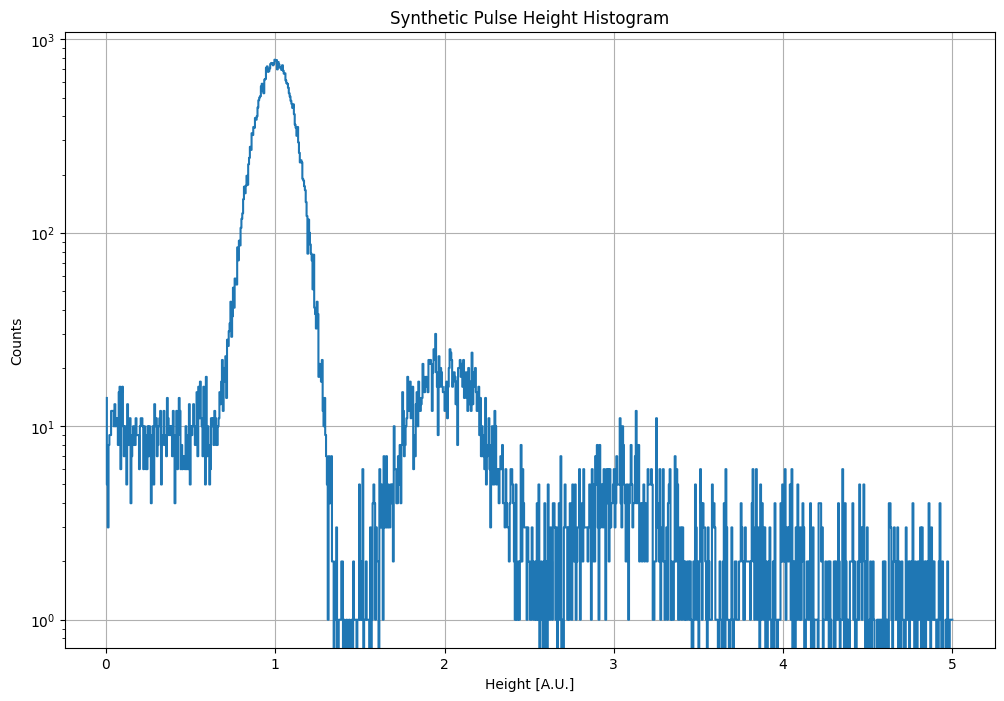

In [38]:
n, bins, _ = plt.hist(all_amps, bins = 1000, range = [0,5])
plt.clf()

plt.figure(figsize=(12,8))
plt.step(bins[1:], n)
plt.title("Synthetic Pulse Height Histogram")
plt.xlabel("Height [A.U.]")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.show()

In [21]:
print(len(ap_amps)/len(amps))
print(len(xt_amps)/len(amps))

0.05167044914762232
0.11041325803557292


## That function seems to work well and to reproduce results, let's use it 

It would be nice to be able to create amplitudes first and store them, so that we can compare the overall results at the end 

In [22]:
num_wfs = 1000
wf_len = 6000

In [23]:
"""
TODO: we might not need to sample from the uniform distribution for AP, we might just straight up sample the binomial
as a 0 count from the binomial distribution is possible -- see if this way we can recover the afterpulsing probability

This one also generates the amplitudes as it creates the timings 
"""

def ap_recovery(dts, recovery_time):
    return 1-np.exp(-1*np.array(dts)/recovery_time)


mu = 1-(1/avg_xt_num) # shape parameter of the Borel distribution for XT


wf_t0s = [] # an array of all of the positions of the t0s 
wf_dts = [] # an array of all of the delay times between dark count events

wf_xt_t0s = [] # an array of all of the positions of cross talk events
wf_xt_dts = [] 
wf_num_xts = [] # an array containing the number of cross talk discharges 

wf_ap_t0s = [] # an array of all positions of afterpulsing events 
wf_ap_dts = [] # an array of all of the afterpulse delay times, can check against it later
wf_num_aps = [] # an array containing the number of afterpulses from k-number of XT events, based on a binomial
wf_num_xts_per_ap = []

dcr_amps = []
xt_amps = []
ap_amps = []


for i in range(num_wfs):
    t0s = [] # an array of all of the positions of the t0s 
    dts = [] # an array of all of the delay times between dark count events

    xt_t0s = [] # an array of all of the positions of cross talk events
    xt_dts = [] 
    num_xts = [] # an array containing the number of cross talk discharges 

    ap_t0s = [] # an array of all positions of afterpulsing events 
    ap_dts = [] # an array of all of the afterpulse delay times, can check against it later
    num_aps = [] # an array containing the number of afterpulses from k-number of XT events, based on a binomial
    num_xts_per_ap = []


    # Keep sampling until we are outside the waveform
    position = 0
    while position < wf_len: 
        dt0 = expon.rvs(0, DCR, size=1)[0] # the exponential distribution is defined by loc, scale like anything in scipy.stats
        # Advance the position by this dt
        position += dt0
        
        if position > wf_len:
            break
            
        if position in ap_t0s:
            pass
        
        else:


            # Now see if we get any XTs or APs
            num = 1 # set default to the 1 DC already created
            if P_xt >= uniform.rvs(size=1)[0]:
                # The number of XT events is determined by a Borel distribution 
                num += borel.rvs(mu, size=1)[0]
                num_xts.append(num)
                xt_t0s.append(position)
                xt_dts.append(dt0)
                
            else:            
                # If we're still inside the wf_len, then save it and the delay time 
                # Save the dark counts
                dts.append(dt0)
                t0s.append(position)
                

            num_ap = 0
            if P_ap >= uniform.rvs(size=1)[0]:
                # The number of AP events from the k-number of XT events above is determined by a Binomial distribution
                while num_ap == 0: # make sure we don't get 0 afterpulses 
                    num_ap = binom.rvs(num, alpha, size=1)[0] + 1
                num_aps.append(num_ap)
                for i in range(num_ap):
                    dt_ap = expon.rvs(0, AP_rate, size=1)[0] 
                    if position + dt_ap <= wf_len:
                        num_xts_per_ap.append(num)
                        ap_t0s.append(position+dt_ap)
                        ap_dts.append(dt_ap)

    # Create amplitudes for the dcrs and xts
    dcr_amps.append(norm.rvs(mu_dcr, sigma_detector, size=len(t0s)))
    xt_amps.append(np.array(num_xts) * norm.rvs(mu_dcr, sigma_detector, size=len(xt_t0s)))
    
    # Create amplitude for the APs
    lap_amps = ap_recovery(ap_dts, AP_rate)
    lap_amps = np.array(num_xts_per_ap) * lap_amps
    ap_amps.append(lap_amps * norm.rvs(mu_dcr, sigma_detector, size=len(ap_t0s)))

    # Save all of the info, each list in the list of lists is one waveform's info
    wf_dts.extend(dts) # for book-keeping
    wf_t0s.append(t0s) # append
    wf_num_xts.append(num_xts) # append
    wf_xt_t0s.append(xt_t0s) # append
    wf_xt_dts.extend(xt_dts)
    wf_num_aps.append(num_aps)  # append
    wf_num_xts_per_ap.append(num_xts_per_ap)  # append
    wf_ap_t0s.append(ap_t0s)  # append
    wf_ap_dts.extend(ap_dts)

    
    
# Create the flat arrays that have all the amplitude info that we need
actual_amps = np.concatenate(np.array(dcr_amps, dtype='object')).flatten()
flat_xt_amps = np.concatenate(np.array(xt_amps, dtype='object')).flatten()
flat_ap_amps = np.concatenate(np.array(ap_amps, dtype='object')).flatten()

actual_amps = np.append(actual_amps, flat_xt_amps)
actual_amps = np.append(actual_amps, flat_ap_amps)



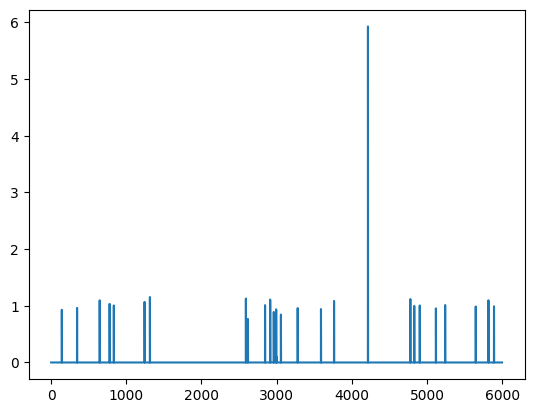

In [24]:
# Make one synthetic waveform, just put in dirac spikes
ts = np.arange(0, wf_len)
wf = np.zeros(len(ts))
def ap_recovery(dts, recovery_time):
    return 1-np.exp(-1*np.array(dts)/recovery_time)

# Put in the dark counts
for j, i in enumerate(wf_t0s[0]):
    wf[int(i)] = dcr_amps[0][j] 

# put in the cross talks 
for j, i in enumerate(wf_xt_t0s[0]):
    wf[int(i)] =   xt_amps[0][j]

# put in the afterpulses
for j, i in enumerate(wf_ap_t0s[0]):
    wf[int(i)] = ap_amps[0][j]


plt.plot(ts, wf)
plt.show()

In [25]:
# now create all the waveforms 
wfs = [] 
ts = np.arange(0, wf_len)

for k in range(num_wfs):
    # Make one synthetic waveform, just put in dirac spikes
    wf = np.zeros(len(ts))

    # Put in the dark counts
    for j, i in enumerate(wf_t0s[k]):
        wf[int(i)] = dcr_amps[k][j]   

    # put in the cross talks 
    for j, i in enumerate(wf_xt_t0s[k]):
        wf[int(i)] = xt_amps[k][j]

    # put in the afterpulses
    for j, i in enumerate(wf_ap_t0s[k]):
        wf[int(i)] =  ap_amps[k][j]
        
    wfs.append(wf)

### try a simple peak finding routine to see if we can recover the PHS 

In [26]:
from scipy.signal import find_peaks 

In [27]:
print(len(wfs))
amps = [] 
plot = False

for wf in wfs[:]: 
    peaks, _ = find_peaks(wf, height=0.001, distance = 1, width=1)
    amps.extend(wf[peaks])
    
    if plot:
        plt.plot(ts, wf)
        plt.scatter(ts[peaks], wf[peaks])
        plt.show()
    

1000


<Figure size 640x480 with 0 Axes>

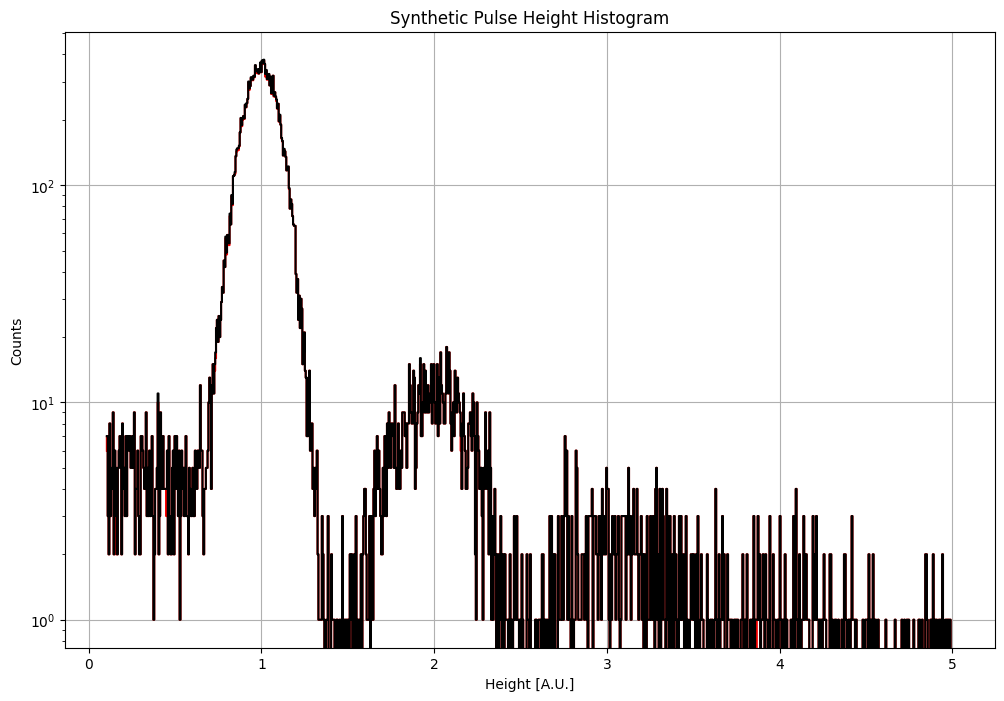

In [28]:
n, bins, _ = plt.hist(amps, bins = 1000, range = [0.1,5])
plt.clf()

n_actual, bins_actual, _ = plt.hist(actual_amps, bins = 1000, range = [0.1,5])
plt.clf()

plt.figure(figsize=(12,8))
plt.step(bins[1:], n, label = 'Recovered', c='r')
plt.step(bins_actual[1:], n_actual, label='Actual', c='k')
plt.title("Synthetic Pulse Height Histogram")
plt.xlabel("Height [A.U.]")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.show()


In [29]:
print(len(np.where(np.array(amps)>1.5)[0])/len(np.where(np.array(amps)>0.5)[0]))
print(len(wf_xt_dts)/(len(wf_dts) + len(wf_xt_dts)))

0.09604907975460122
0.09699248120300752


I can recover the cross talk fraction exactly (to within 0.05% accuracy), now we are ready to move on to putting in real synthetic pulses. 

For the gain, when we create the synthetic pulses, we start at the first event in the waveform, and put some 0s in front of it, so that every waveform starts on a trigger with some pretrigger window. 

In [235]:
from scipy import signal 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

In [236]:
Rs = 50 # 50 ohm shunt resistance to connect to Oscope or amp
N = 3600 # number of microcells


def sipm_duara_model(Rq, Rd, Cd, Cf, Cq, Cg, dV): 
    b1 = Rq*(Cd + 2*Cq)
    b2 = Rq**2*Cq*(Cd + Cq)
    a1 = 2*Rq*(Cd + Cq) + Rs*(Cg + N*Cd)
    a2 = Rq*(N*Cd*Rs*(Cd + 2*Cq) + Rq*(Cd + Cq)**2 + 2*Cg*Rs*(Cd + Cq))
    a3 = Rq**2*Rs*(Cd + Cq)*(N*Cd*Cq + Cg*(Cd + Cq))
    alpha = N*dV*Cf*Rs
    
    num = [alpha*b2, alpha*b1, alpha]
    den = [Rd*Cd*a3, Rd*Cd*a2 + a3, Rd*Cd*a1 + a2, Rd*Cd + a1, 1]
    
#     print(num, den)
    return signal.TransferFunction(num, den)
    

In [237]:
paper_params_model = sipm_duara_model(535.72e3, 4.29e3, 235.07e-15, 382.78e-15, 157.92e-15, 1424.74e-12, 1)

In [238]:
def model_fit(t, t0_idx, Rq, Rd, Cd, Cf, Cq, Cg, dV): 
    if np.isnan(t0_idx):
        return np.zeros(len(t))
    fit_model = sipm_duara_model(Rq, Rd, Cd, Cf, Cq, Cg, dV)
    N_samples = len(t[int(t0_idx):]) 
    if (N_samples == 0) or (N_samples == 1):
        return np.zeros(len(t)) 
    t_model, y = signal.impulse(fit_model, N=1000)
    out = np.insert(y, 0, np.zeros(int(t0_idx))) # insert 0s at the start before t0
    out = out[:len(t)]
    return out
    

In [239]:
import h5py
f_name = "/Users/SamBorden 1/Desktop/Jason work/arbitrary transfer function/t1_Data_CH0@DT5730_1463_hamamatsu_dark_rt_03062023_545dv.BIN.h5"


f = h5py.File(f_name, 'r')
f.keys()
wfs = f['raw/waveforms'][:]
f.close()

fit_wf = wfs[0]
# convert the ADC to voltage very quickly 
fit_wf =  np.array(fit_wf) * 2/(np.power(2, 14))
# baseline subtract 
fit_wf -= np.mean(fit_wf[:20])



In [240]:
from iminuit import Minuit
t = np.arange(len(fit_wf))

def cost_function(t0_idx, Rq, Rd, Cd, Cf, Cq, Cg, dV):
    value = 0 
    wf_out = model_fit(t, t0_idx, Rq, Rd, Cd, Cf, Cq, Cg, dV)
    for i in range(0, len(t)):
        value += np.power(fit_wf[i]-wf_out[i], 2) # LSQ
    return value

m = Minuit(cost_function, t0_idx=61.99640377479186, Rq=48594.34362570377, Rd=89385.0239462482, Cd=4.3841789753507454e-13, Cf=3.8832452178866493e-13, Cq=2.916821229330914e-11, Cg=7.659473131527615e-09, dV=1.2301348487624806)


m.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.01698                    │              Nfcn = 629              │
│ EDM = 1.03e-05 (Goal: 0.0002)    │            time = 2.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ t0_idx │  61.997   │   0.006   │            │            │         │         │       │
│ 1 │ Rq     │ 48.5943e3 │ 0.0014e3  │            │            │         │         │       │
│ 2 │ Rd     │ 45.7793e3 │ 0.0014e3  │            │            │         │         │       │
│ 3 │ Cd     │  0.2e-12  │  2.4e-12  │            │            │         │         │       │
│ 4 │ Cf     │  0.3e-12  │  0.5e-12  │            │            │         │         │       │
│ 5 │ Cq     │ 0.033e-9  │ 0.029e-9  │            │            │         │         │       │
│ 6 │ Cg     │ 0.004e-6  │ 0.018e-6  │            │            │         │         │       │
│ 7 │ dV     │    0.9    │    1.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────────────┐
│        │    t0_idx        Rq        Rd        Cd        Cf        Cq        Cg        dV │
├────────┼─────────────────────────────────────────────────────────────────────────────────┤
│ t0_idx │  4.15e-05 -5.83e-09  8.78e-09 -2.95e-15 -1.85e-16 -5.45e-15  1.45e-11 -0.000587 │
│     Rq │ -5.83e-09         2  1.38e-10  3.67e-17  9.43e-19 -2.45e-16 -1.89e-13  2.99e-06 │
│     Rd │  8.78e-09  1.38e-10         2 -1.46e-17 -1.62e-18  1.21e-16  7.49e-15 -5.14e-06 │
│     Cd │ -2.95e-15  3.67e-17 -1.46e-17  5.98e-24  6.74e-26  3.39e-23 -2.73e-20  2.13e-13 │
│     Cf │ -1.85e-16  9.43e-19 -1.62e-18  6.74e-26  2.04e-25  2.22e-24   2.9e-21  5.66e-15 │
│     Cq │ -5.45e-15 -2.45e-16  1.21e-16  3.39e-23  2.22e-24   8.6e-22 -1.39e-19  7.02e-12 │
│     Cg │  1.45e-11 -1.89e-13  7.49e-15 -2.73e-20   2.9e-21 -1.39e-19  3.24e-16  9.18e-09 │
│     dV │ -0.000587  2.99e-06 -5.14e-06  2.13e-13  5.66e-15  7.02e-12  9.18e-09      2.05 │
└────────┴─────────────────────────────────────────────────────────────────────────────────┘

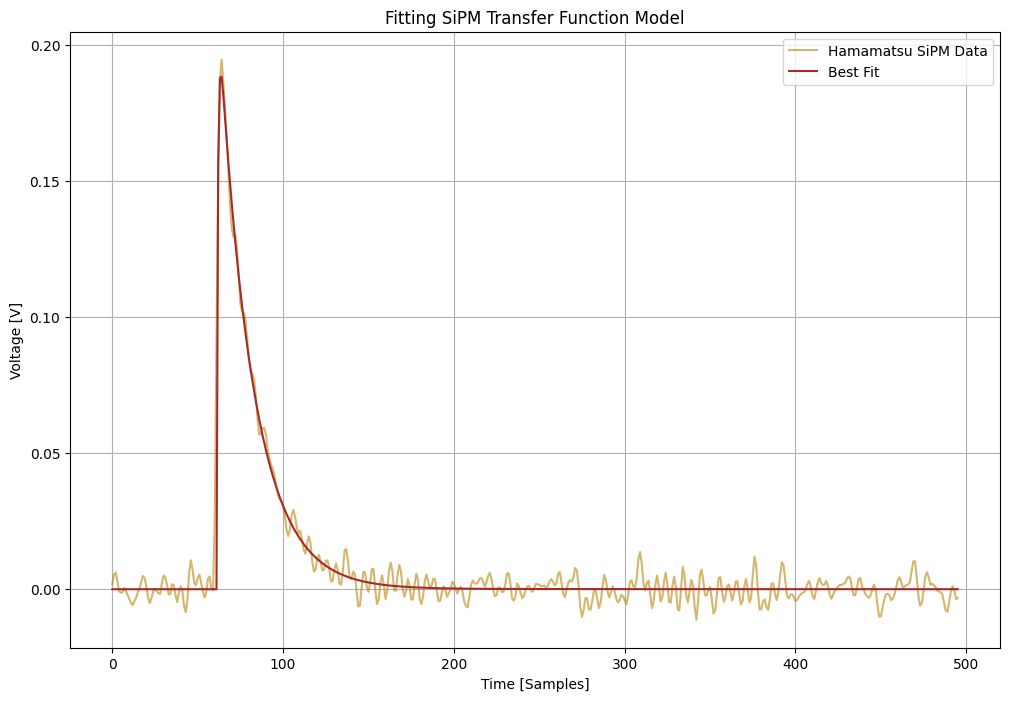

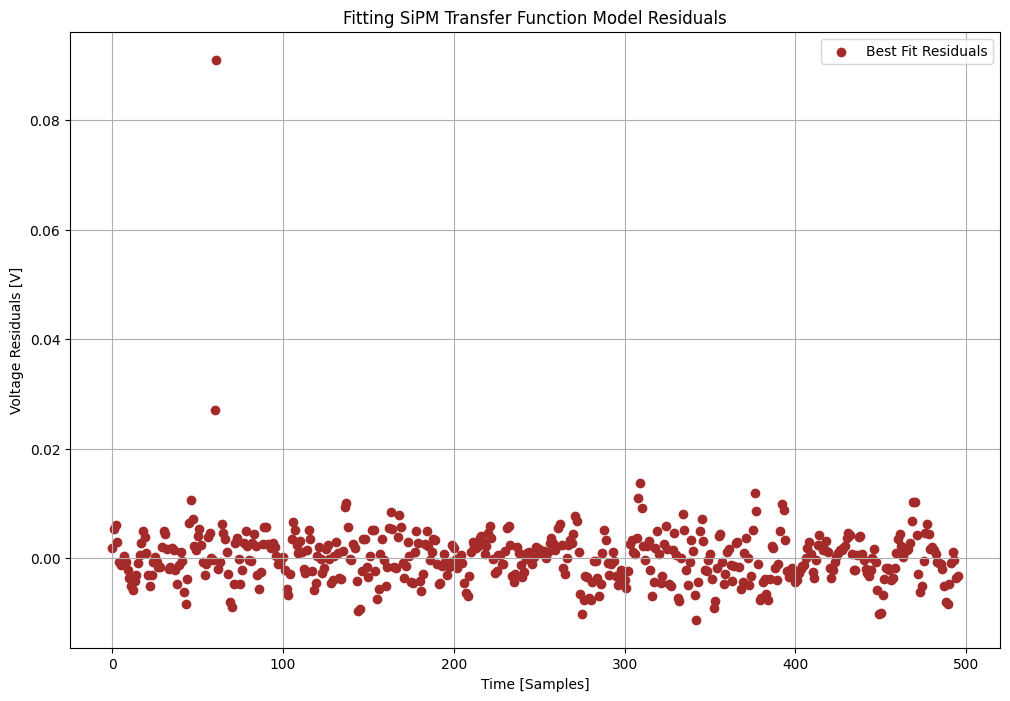

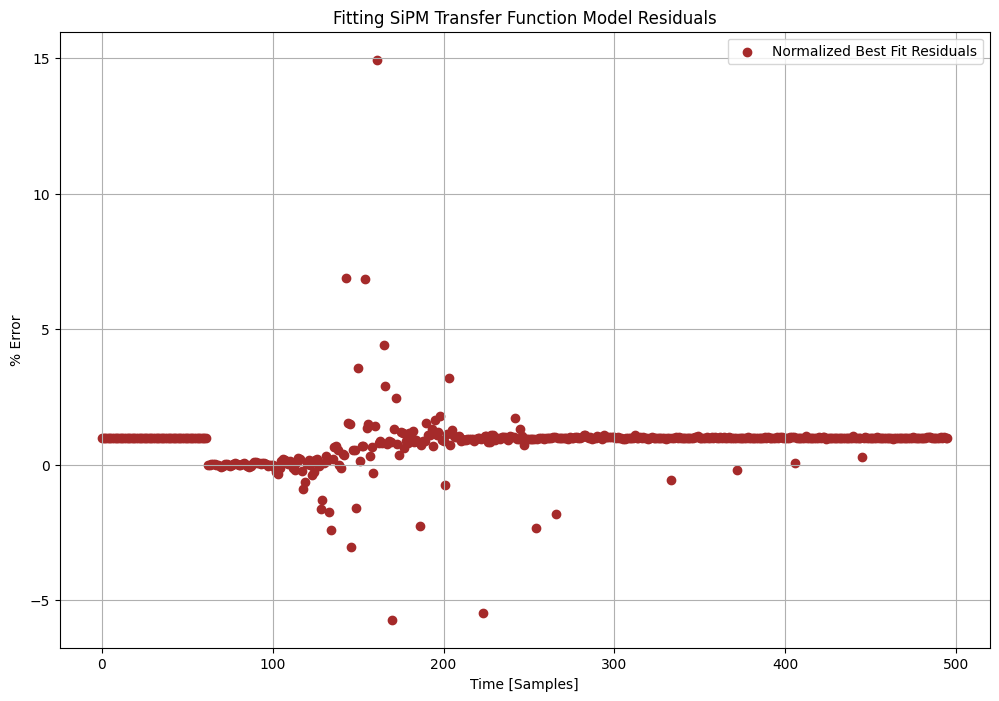

0.032960752282617786


In [241]:
sipm_params = m.values[1:]

y_out = model_fit(t, *m.values)
duara_pulse = y_out[:]
plt.figure(figsize = (12,8))
plt.grid(True)
plt.plot(t, fit_wf, alpha = 0.6, label = 'Hamamatsu SiPM Data', c='darkgoldenrod')
plt.plot(t, y_out, label = 'Best Fit', c='brown')
plt.title("Fitting SiPM Transfer Function Model")
plt.xlabel("Time [Samples]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.show()


plt.figure(figsize = (12,8))
plt.grid(True)
# plt.plot(t, fit_wf, alpha = 0.6, label = 'LEGEND SiPM Data', c='darkgoldenrod')
plt.scatter(t, fit_wf-y_out, label = 'Best Fit Residuals', c='brown')
plt.title("Fitting SiPM Transfer Function Model Residuals")
plt.xlabel("Time [Samples]")
plt.ylabel("Voltage Residuals [V]")
plt.legend()
plt.show()


plt.figure(figsize = (12,8))
plt.grid(True)
# plt.plot(t, fit_wf, alpha = 0.6, label = 'LEGEND SiPM Data', c='darkgoldenrod')
plt.scatter(t, (fit_wf-y_out)/fit_wf, label = 'Normalized Best Fit Residuals', c='brown')
plt.title("Fitting SiPM Transfer Function Model Residuals")
plt.xlabel("Time [Samples]")
plt.ylabel("% Error")
plt.legend()
plt.show()


def chi_square(data, model):
    return np.sum((data-model)**2/data)

print(chi_square(fit_wf, y_out))




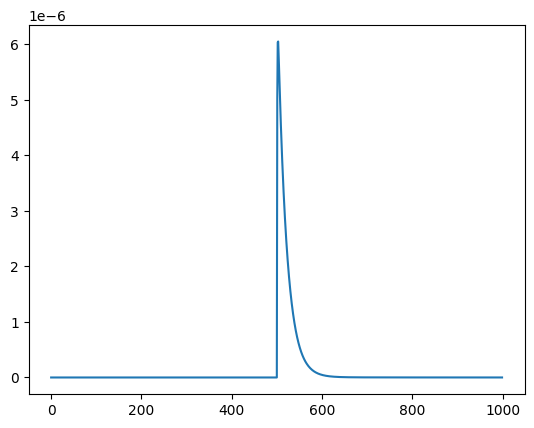

1691972.9992003716


In [247]:
# Find the gain of the single pulse 

## convert the V back to LSB: 

new_pulse = model_fit(np.arange(0, 1000), 500, *m.values[1:])

pulse = new_pulse * (2**14/2)

from sipm_studio.dsp.adc_to_current import current_converter

I_pulse = current_converter(pulse, 2, 14, "sipm")

plt.plot(I_pulse)
plt.show()

from sipm_studio.dsp.current_to_charge import integrate_current

qs = integrate_current(np.array([I_pulse]), 0, 1000, 2e-9)

gain = qs/1.6e-19

print(np.sum(I_pulse[:-1])*2e-9/1.6e-19)

In [234]:
gain

array([3930715.92666857])

In [38]:
wfs = [] 
ts = np.arange(0, wf_len)

for k in range(num_wfs):
    # Make one synthetic waveform, just put in dirac spikes
    wf = np.zeros(len(ts))

    # Put in the dark counts
    for j, i in enumerate(wf_t0s[k]):
        wf += dcr_amps[k][j] * model_fit(ts, int(i), *sipm_params)  

    # put in the cross talks 
    for j, i in enumerate(wf_xt_t0s[k]):
        wf +=  xt_amps[k][j] * model_fit(ts, int(i), *sipm_params)

    # put in the afterpulses
    for j, i in enumerate(wf_ap_t0s[k]):
        wf += ap_amps[k][j] * model_fit(ts, int(i), *sipm_params)

    wfs.append(wf)

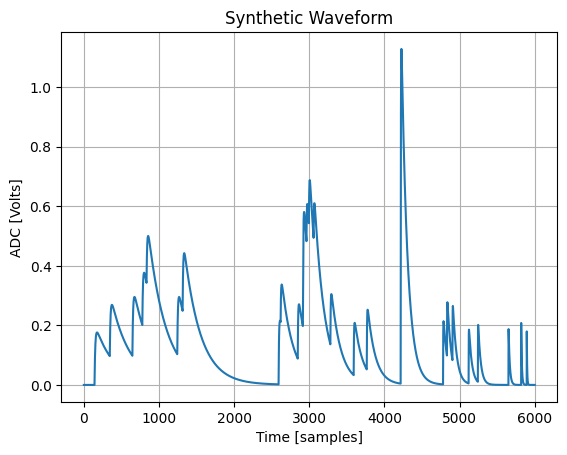

In [37]:
# Make one synthetic waveform, just put in dirac spikes
ts = np.arange(0, wf_len)
wf = np.zeros(len(ts))

# Put in the dark counts
for j, i in enumerate(wf_t0s[0]):
    wf += dcr_amps[0][j] * model_fit(ts, int(i), *sipm_params)

# put in the cross talks 
for j, i in enumerate(wf_xt_t0s[0]):
    wf +=  xt_amps[0][j] * model_fit(ts, int(i), *sipm_params)

# put in the afterpulses
for j, i in enumerate(wf_ap_t0s[0]):
    wf += ap_amps[0][j] * model_fit(ts, int(i), *sipm_params)


plt.plot(ts, wf)
plt.ylabel("ADC [Volts]")
plt.xlabel("Time [samples]")
plt.title("Synthetic Waveform")
plt.grid(True)
plt.show()

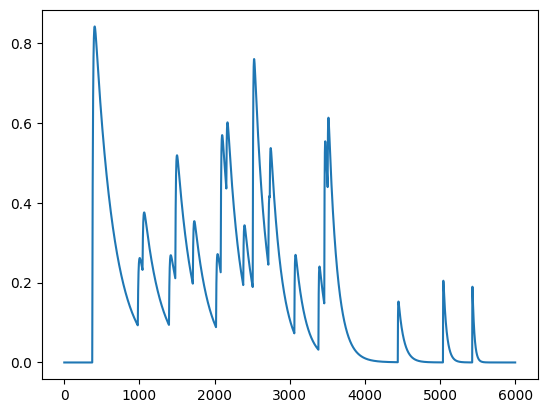

In [39]:
plt.plot(wfs[2])

### Try creating defaults so that we can test the gain processors 

In [1]:
gain = 1.7e6 # typical gain from a SiPM 
DCR = 700 # this is in counts per second, let's convert to samples using the sampling rate of the digitizer

P_xt = 0.2 # these are made up, but probability that a DC creates direct cross talk
avg_xt_num = 5 # average number of direct cross talk discharges per DC


P_ap = 0.01 # also made up, probability for afterpulsing 
cell_recovery = 100 # no idea, just again assume exponential inter-time from the main DC, this is also the cell recovery time!
alpha = 0.001 # probability that Geiger discharge (from DC + XT events) causes an AP, keep this extremely small

sampling_rate = 1 # 2ns per sample 
DCR /= sampling_rate # DCR in counts/sample

sigma_detector  = 0.08


In [30]:
# num_wfs = 200000
# num_wfs = 2000
num_wfs = 20000
wf_len = 500

In [31]:
from sipm_studio.simulations.simulate_sipm_response import sipm, simulate_t0s

In [32]:
new_sipm = sipm(gain, DCR, P_xt, avg_xt_num, P_ap, cell_recovery, alpha, 0.1)

In [33]:
synth = simulate_t0s(num_wfs, wf_len, new_sipm, sigma_detector)

In [34]:
synth.calculate_xt()

0.19419250509737748

In [35]:
synth.calculate_ap()

0.007874569359488152

In [36]:
amps = synth.full_amplitudes()

<Figure size 640x480 with 0 Axes>

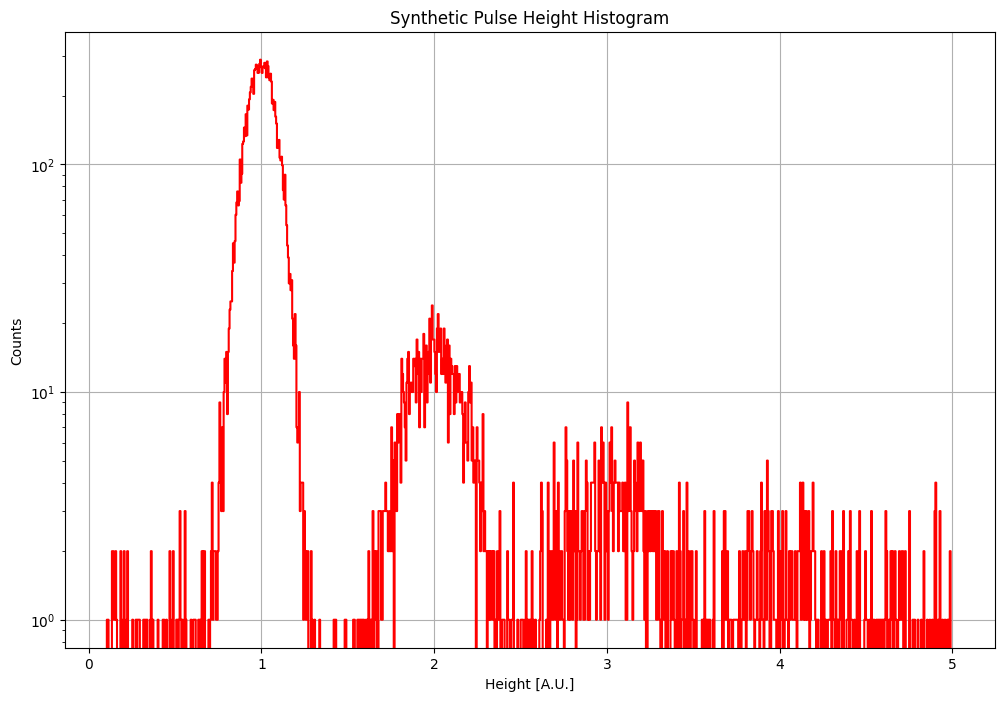

In [37]:
import matplotlib.pyplot as plt 

n, bins, _ = plt.hist(amps, bins = 1000, range = [0.1,5])
plt.clf()

plt.figure(figsize=(12,8))
plt.step(bins[1:], n, label = 'Recovered', c='r')
plt.title("Synthetic Pulse Height Histogram")
plt.xlabel("Height [A.U.]")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.show()


In [38]:
wfs = synth.create_quick_gain_duara_wfs(50)

In [39]:
from sipm_studio.dsp.current_to_charge import integrate_current

In [40]:
import numpy as np 
wfs = np.array(wfs)
qs = integrate_current(wfs, 45, 250, 1)

<Figure size 640x480 with 0 Axes>

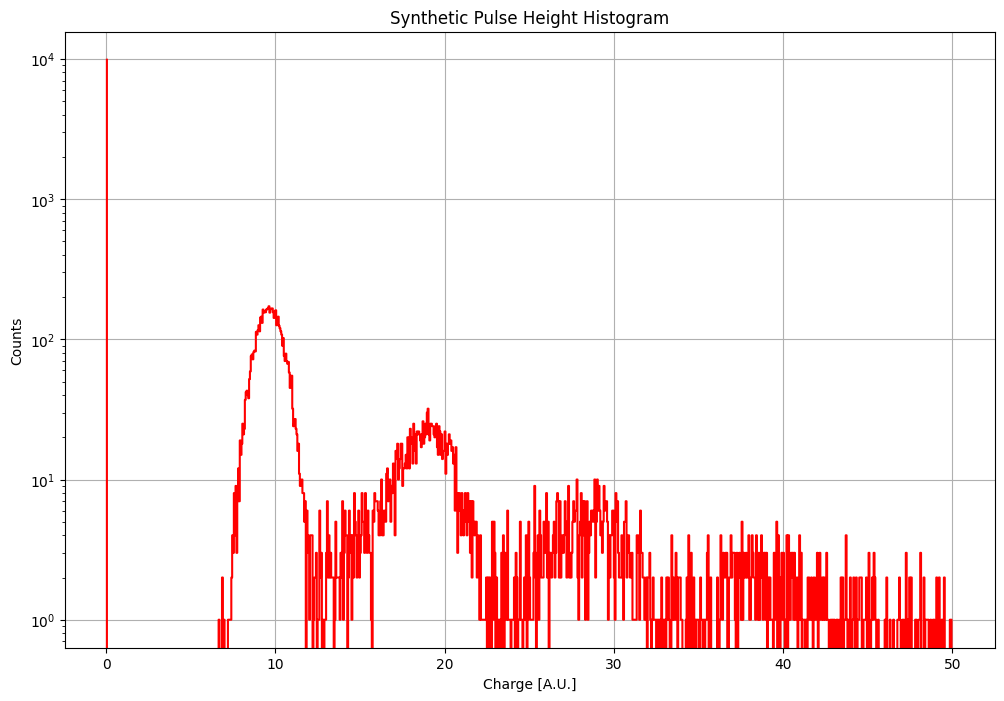

In [41]:
import matplotlib.pyplot as plt 

n, bins, _ = plt.hist(qs, bins = 1000, range=[0,50])
plt.clf()

plt.figure(figsize=(12,8))
plt.step(bins[1:], n, label = 'Recovered', c='r')
plt.title("Synthetic Pulse Height Histogram")
plt.xlabel("Charge [A.U.]")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.show()


In [42]:
selected_wfs = np.array(wfs[qs>1])
scaled_wfs = selected_wfs * (2**14/2)
bls = np.zeros_like(scaled_wfs)

In [60]:

# import h5py 
# f_out = h5py.File("/Users/SamBorden 1/Desktop/Jason work/sipm_studio/tests/gain/configs/gain_wfs.h5", 'a')



In [61]:
# dset = f_out.create_dataset("/raw/waveforms", data=scaled_wfs)
# dset = f_out.create_dataset("/raw/baselines", data=bls)
# dset = f_out.create_dataset("P_xt", data=P_xt)
# dset = f_out.create_dataset("P_ap", data=P_ap)
# dset = f_out.create_dataset("DCR", data=DCR)

In [62]:
# f_out.close()

In [20]:
import h5py 
f_out = h5py.File("/Users/SamBorden 1/Desktop/Jason work/sipm_studio/tests/gain/configs/gain_wfs.h5", 'r')
scaled_wfs  = f_out["/raw/waveforms"][:]

f_out.close()

In [43]:
from sipm_studio.dsp.adc_to_current import current_converter
current_synth_wf = current_converter(scaled_wfs, 2, 14, "sipm")

In [44]:
from sipm_studio.dsp.current_to_charge import integrate_current

qs = integrate_current(current_synth_wf, 45, 250, 2e-9)

<Figure size 640x480 with 0 Axes>

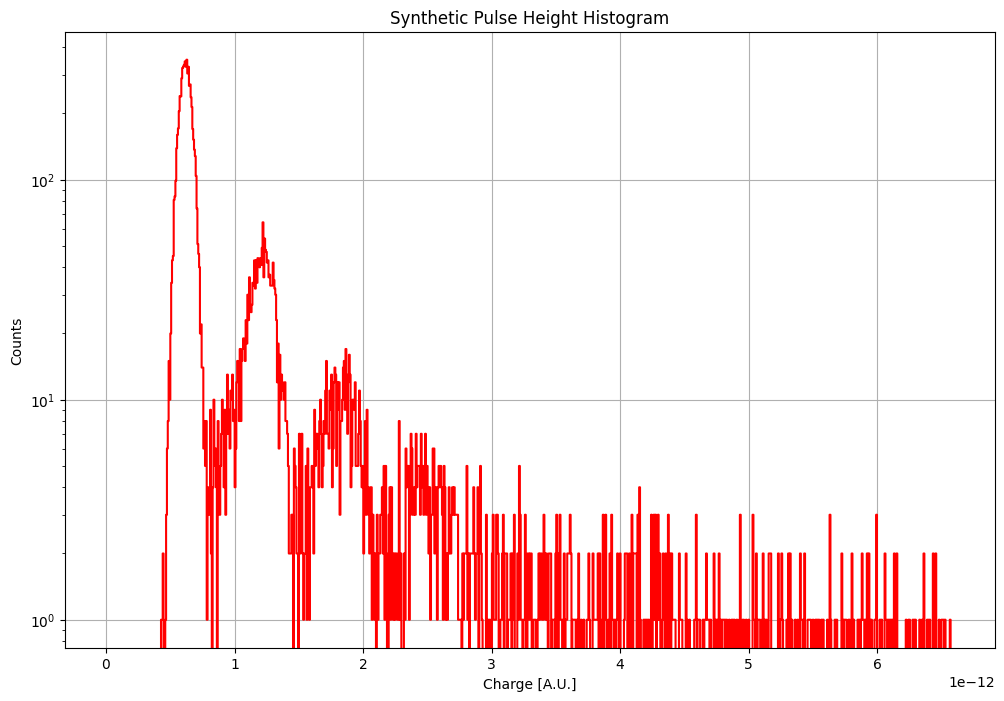

In [45]:
import matplotlib.pyplot as plt
import numpy as np 

n, bins, _ = plt.hist(qs, bins = 1000, range=[0, 10*np.median(qs)])
plt.clf()

plt.figure(figsize=(12,8))
plt.step(bins[1:], n, label = 'Recovered', c='r')
plt.title("Synthetic Pulse Height Histogram")
plt.xlabel("Charge [A.U.]")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.show()


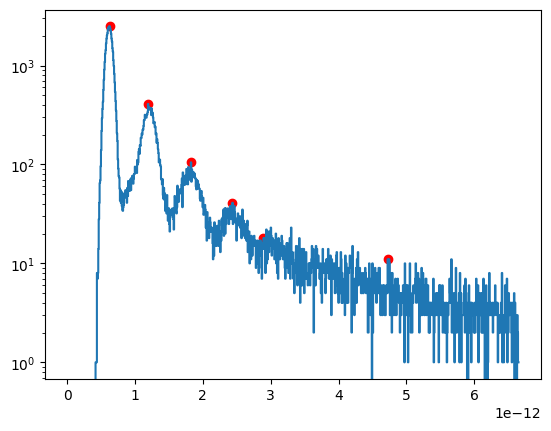

In [24]:
from scipy.signal import find_peaks 

peaks, amps = find_peaks(n, distance = 13, width = 5)

plt.scatter(bins[peaks], n[peaks], c='r')
plt.step(bins[1:], n)
plt.yscale('log')
plt.show()

In [46]:
from sipm_studio.dsp.qpe_peak_finding import guess_peaks, fit_peaks, gaussian

In [51]:
peaks, peak_locs, amps = guess_peaks(n, bins, min_height = 10, min_dist = 5e-13, min_width = 1.1e-14)

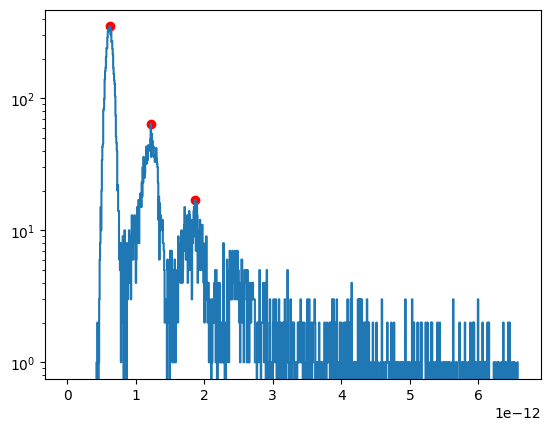

In [52]:
plt.scatter(bins[peaks], n[peaks], c='r')
plt.step(bins[1:], n)
plt.yscale('log')
plt.show()

In [53]:
params, param_err = fit_peaks(n, bins, peaks, peak_locs, amps, fit_width = 15)

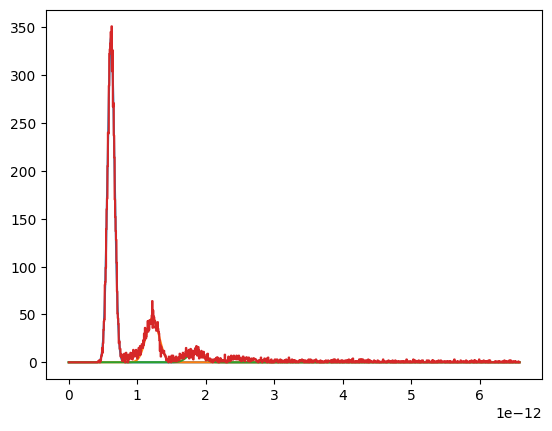

In [54]:
xs = np.linspace(0, 10*np.median(qs), 1000)
for i in range(len(params)):
    plt.plot(xs, gaussian(xs, *params[i]))
    
    
plt.step(bins[1:], n)
# plt.yscale('log')
plt.show()

In [55]:
from sipm_studio.dsp.gain_processors import normalize_charge,slope_fit_gain 

In [56]:
centroid = []
centroid_err = []
for i, x in enumerate(params):
    centroid.append(x[1])
    centroid_err.append(param_err[i][1])

gain, charges, gain_err = normalize_charge(qs, centroid, centroid_err)

3903639.1312488234


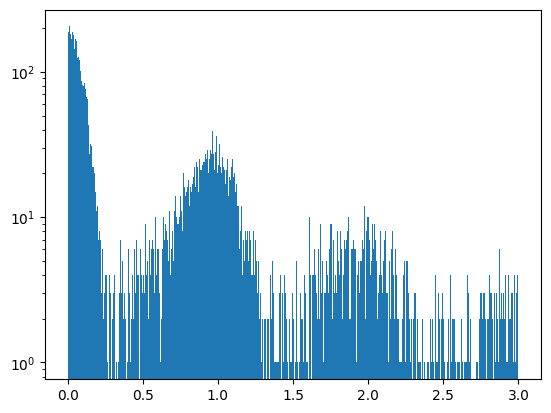

In [57]:
print(gain)
n, bins,  _ = plt.hist(charges, range = [0,3], bins=500)
plt.yscale('log')
plt.show()

In [58]:
slope_fit_gain(centroid)

array([3843238.8997918 ,   34872.08989082])

In [59]:
np.array(centroid)/1.6e-19

array([ 3871265.35515784,  7654104.02349263, 11557743.15474145])

# Make a light simulation 
Let the number of photons from a pulsed light source be given by a Poisson distribution with mean $N_\gamma$. Then roll in the probability that N_cells discharging will give a certain number of cross talk and afterpulses. 

In [18]:
N_gamma = 3 # mean number of photons from the LED light source 

gain = 1.7e6 # typical gain from a SiPM 
DCR = 300 # this is in counts per second, let's convert to samples using the sampling rate of the digitizer

P_xt = 0.0 # these are made up, but probability that a DC creates direct cross talk
avg_xt_num = 2 # average number of direct cross talk discharges per DC


P_ap = 0.00 # also made up, probability for afterpulsing 
AP_rate = 30 # no idea, just again assume exponential inter-time from the main DC, this is also the cell recovery time!
alpha = 0.001 # probability that Geiger discharge (from DC + XT events) causes an AP, keep this extremely small

sampling_rate = 1 # 2ns per sample 
DCR /= sampling_rate # DCR in counts/sample

sigma_detector=0.1
mu_dcr=1


In [19]:
num_wfs = 10000
wf_len = 200
led_trig_pos = 100

In [20]:
"""
TODO: we might not need to sample from the uniform distribution for AP, we might just straight up sample the binomial
as a 0 count from the binomial distribution is possible -- see if this way we can recover the afterpulsing probability

This one also generates the amplitudes as it creates the timings 
"""

def ap_recovery(dts, recovery_time):
    return 1-np.exp(-1*np.array(dts)/recovery_time)


mu = 1-(1/avg_xt_num) # shape parameter of the Borel distribution for XT


wf_t0s = [] # an array of all of the positions of the t0s 
wf_dts = [] # an array of all of the delay times between dark count events

wf_xt_t0s = [] # an array of all of the positions of cross talk events
wf_xt_dts = [] 
wf_num_xts = [] # an array containing the number of cross talk discharges 

wf_ap_t0s = [] # an array of all positions of afterpulsing events 
wf_ap_dts = [] # an array of all of the afterpulse delay times, can check against it later
wf_num_aps = [] # an array containing the number of afterpulses from k-number of XT events, based on a binomial
wf_num_xts_per_ap = []

dcr_amps = []
xt_amps = []
ap_amps = []


led_amps = [] # an array of the number of cells fired in the LED pulse 
led_ap_amps = []

led_t0s = []

led_xt_t0s = [] # an array of all of the positions of cross talk events in an LED pulse
led_xt_dts = [] 
led_num_xts = [] # an array containing the number of cross talk discharges during the LED pulse

led_ap_t0s = [] # an array of all positions of afterpulsing events 
led_ap_dts = [] # an array of all of the afterpulse delay times, can check against it later
led_num_aps = [] # an array containing the number of afterpulses from k-number of XT events, based on a binomial
led_num_xts_per_ap = []

for i in range(num_wfs):
    t0s = [] # an array of all of the positions of the t0s 
    dts = [] # an array of all of the delay times between dark count events

    xt_t0s = [] # an array of all of the positions of cross talk events
    xt_dts = [] 
    num_xts = [] # an array containing the number of cross talk discharges 

    ap_t0s = [] # an array of all positions of afterpulsing events 
    ap_dts = [] # an array of all of the afterpulse delay times, can check against it later
    num_aps = [] # an array containing the number of afterpulses from k-number of XT events, based on a binomial
    num_xts_per_ap = []
    
    led_ap_t0s = [] # an array of all positions of afterpulsing events 
    led_ap_dts = [] # an array of all of the afterpulse delay times, can check against it later
    led_num_aps = [] # an array containing the number of afterpulses from k-number of XT events, based on a binomial
    led_num_xts_per_ap = []

    # At the LED trigger position, sample a Poisson distribution to see the number of cells fired
    # Then determine AP and XT corrections to that number of cells firing
    led_t0s.append([led_trig_pos])
    N_cells = np.random.poisson(N_gamma, size=1)[0]
    
    num_led = N_cells # the overall number of cells fired from cross talk and LED
    for i in range(N_cells):
        # Now see if we get any XTs or APs
        if P_xt >= uniform.rvs(size=1)[0]:
            # The number of XT events is determined by a Borel distribution 
            num_led += borel.rvs(mu, size=1)[0]
            
        led_num_ap = 0
        if P_ap >= uniform.rvs(size=1)[0]:
            # The number of AP events from the k-number of XT events above is determined by a Binomial distribution
            while led_num_ap == 0: # make sure we don't get 0 afterpulses 
                led_num_ap = binom.rvs(num_led, alpha, size=1)[0] + 1
            led_num_aps.append(led_num_ap)
            for i in range(led_num_ap):
                led_dt_ap = expon.rvs(0, AP_rate, size=1)[0] 
                if led_trig_pos + led_dt_ap <= wf_len:
                    led_num_xts_per_ap.append(num_led)
                    led_ap_t0s.append(led_trig_pos+led_dt_ap)
                    led_ap_dts.append(led_dt_ap)
        
        

    # Keep sampling until we are outside the waveform
     
    position = 0
    while position < wf_len: 
        dt0 = expon.rvs(0, DCR, size=1)[0] # the exponential distribution is defined by loc, scale like anything in scipy.stats
        # Advance the position by this dt
        position += dt0
        
        if position > wf_len:
            break
            
        if position in ap_t0s:
            pass
        
        if position == led_trig_pos: # If a dark count happens during the LED trigger, count it...
            num_led += 1
            
        
        else:


            # Now see if we get any XTs or APs
            num = 1 # set default to the 1 DC already created
            if P_xt >= uniform.rvs(size=1)[0]:
                # The number of XT events is determined by a Borel distribution 
                num += borel.rvs(mu, size=1)[0]
                num_xts.append(num)
                xt_t0s.append(position)
                xt_dts.append(dt0)
                
            else:            
                # If we're still inside the wf_len, then save it and the delay time 
                # Save the dark counts
                dts.append(dt0)
                t0s.append(position)
                

            num_ap = 0
            if P_ap >= uniform.rvs(size=1)[0]:
                # The number of AP events from the k-number of XT events above is determined by a Binomial distribution
                while num_ap == 0: # make sure we don't get 0 afterpulses 
                    num_ap = binom.rvs(num, alpha, size=1)[0] + 1
                num_aps.append(num_ap)
                for i in range(num_ap):
                    dt_ap = expon.rvs(0, AP_rate, size=1)[0] 
                    if position + dt_ap <= wf_len:
                        num_xts_per_ap.append(num)
                        ap_t0s.append(position+dt_ap)
                        ap_dts.append(dt_ap)

    # Create amplitudes for the dcrs and xts and LED pulses
    dcr_amps.append(norm.rvs(mu_dcr, sigma_detector, size=len(t0s)))
    xt_amps.append(np.array(num_xts) * norm.rvs(mu_dcr, sigma_detector, size=len(xt_t0s)))
    led_amps.append(norm.rvs(num_led, sigma_detector, size=1))
    
    # Create amplitude for the APs
    lap_amps = ap_recovery(ap_dts, AP_rate)
    lap_amps = np.array(num_xts_per_ap) * lap_amps
    ap_amps.append(lap_amps * norm.rvs(mu_dcr, sigma_detector, size=len(ap_t0s)))
    led_lap_amps = ap_recovery(led_ap_dts, AP_rate)
    led_lap_amps = np.array(led_num_xts_per_ap) * led_lap_amps
    led_ap_amps.append(led_lap_amps * norm.rvs(mu_dcr, sigma_detector, size=len(led_ap_t0s)))

    # Save all of the info, each list in the list of lists is one waveform's info
    wf_dts.extend(dts) # for book-keeping
    wf_t0s.append(t0s) # append
    wf_num_xts.append(num_xts) # append
    wf_xt_t0s.append(xt_t0s) # append
    wf_xt_dts.extend(xt_dts)
    wf_num_aps.append(num_aps)  # append
    wf_num_xts_per_ap.append(num_xts_per_ap)  # append
    wf_ap_t0s.append(ap_t0s)  # append
    wf_ap_dts.extend(ap_dts)

    
    
# Create the flat arrays that have all the amplitude info that we need
actual_amps = np.concatenate(np.array(dcr_amps, dtype='object')).flatten()
flat_xt_amps = np.concatenate(np.array(xt_amps, dtype='object')).flatten()
flat_ap_amps = np.concatenate(np.array(ap_amps, dtype='object')).flatten()

actual_led_amps = np.concatenate(np.array(led_amps, dtype='object')).flatten()
actual_led_ap_amps = np.concatenate(np.array(led_ap_amps, dtype='object')).flatten()

actual_amps = np.append(actual_amps, flat_xt_amps)
actual_amps = np.append(actual_amps, flat_ap_amps)

actual_led_amps = np.append(actual_led_amps, actual_led_ap_amps)



<Figure size 640x480 with 0 Axes>

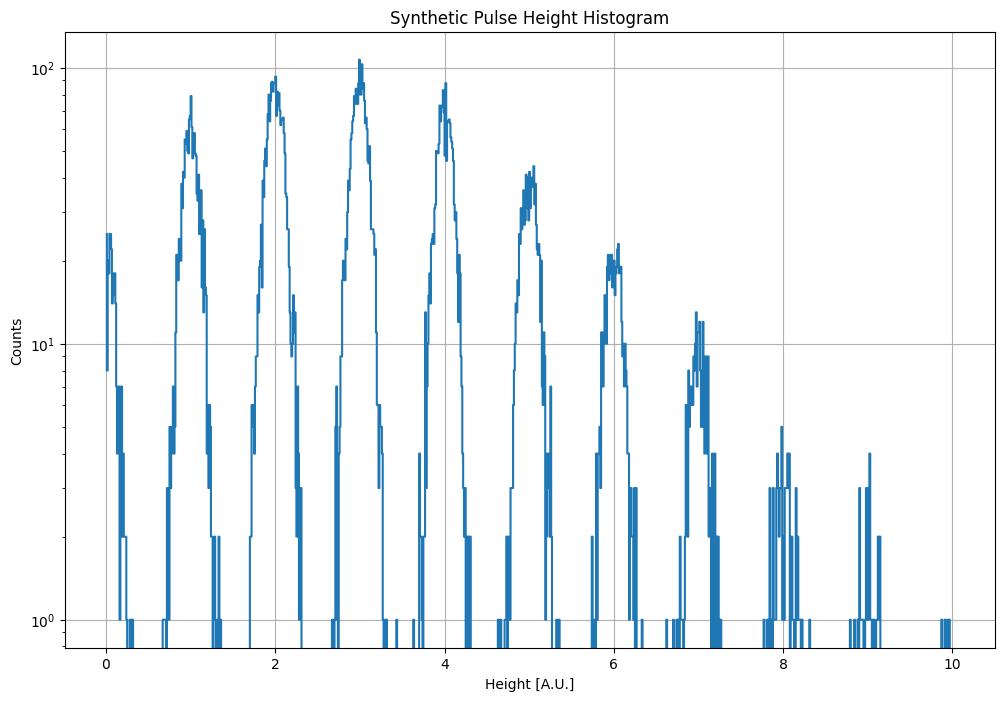

In [21]:
# actual_led_amps_full = actual_led_amps
n, bins, _ = plt.hist(actual_led_amps, bins = 1000, range = [0,10])
plt.clf()

plt.figure(figsize=(12,8))
plt.step(bins[1:], n)
plt.title("Synthetic Pulse Height Histogram")
plt.xlabel("Height [A.U.]")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.show()

<Figure size 640x480 with 0 Axes>

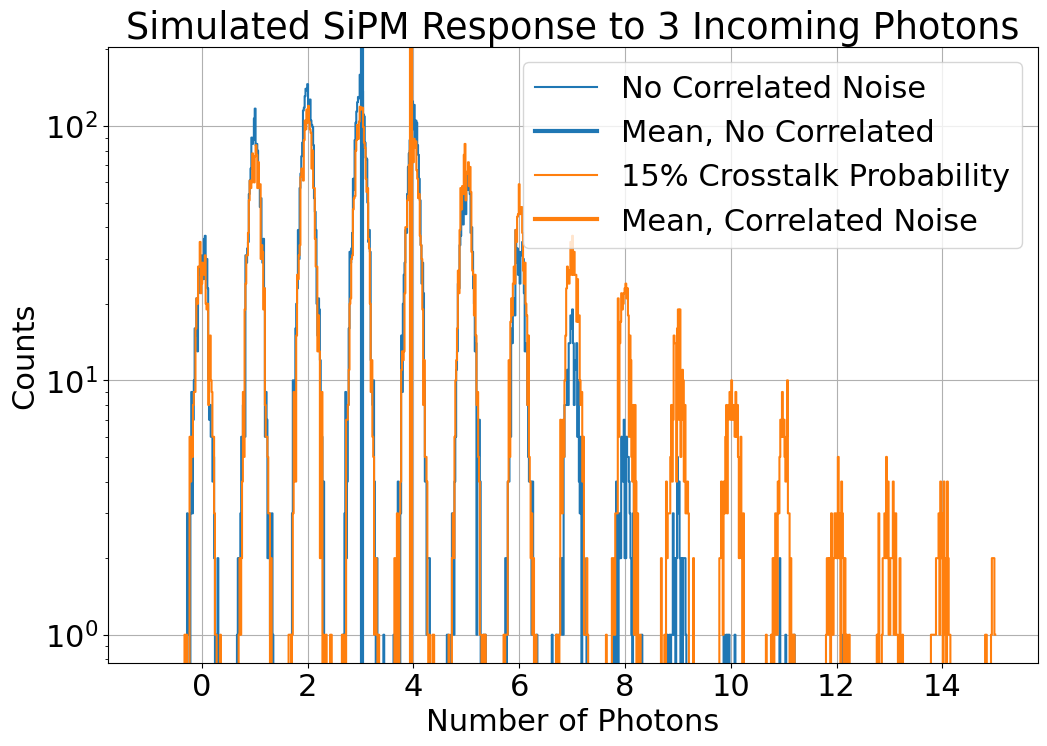

In [27]:
import matplotlib 
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

n, bins, _ = plt.hist(actual_led_amps, bins = 1000, range = [-1,15], label = 'No Correlated Noise')
n_c, bins_c, _ = plt.hist(actual_led_amps_full , bins = 1000, range = [-1,15], label = 'Correlated Noise')
plt.clf()

plt.figure(figsize=(12,8))
plt.step(bins[1:], n, label = 'No Correlated Noise')
plt.axvline(x=np.mean(actual_led_amps), c='C0', label = 'Mean, No Correlated', lw=3)
plt.step(bins_c[1:], n_c, label = '15% Crosstalk Probability')
plt.axvline(x=np.mean(actual_led_amps_full), c='C1', label = 'Mean, Correlated Noise', lw=3)
plt.title("Simulated SiPM Response to 3 Incoming Photons")
plt.xlabel("Number of Photons")
plt.ylabel("Counts")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()
